In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, sys

from numpy import pi, sin, cos, sqrt
from functools import partial
from matplotlib.cm import coolwarm
from matplotlib.animation import FuncAnimation

class Bound_node : 
    pass

class Mesh : 
    def __init__(self, X, Y, dx, dy) :
        self.x_space = np.arange(0, X + dx, dx)
        self.y_space = np.arange(0, Y + dy, dy)
        self.__dx = dx
        self.__dy = dy
        self.__valid_node_num = 0
        self.__valid_node_index = None

        self.xx, self.yy = np.meshgrid(self.x_space, self.y_space, indexing="ij")
        self.grid = np.zeros(shape=(len(self.x_space), len(self.y_space)), dtype=Bound_node)
        self.is_set = False
    
    def return_index(self, x=None, y=None) : 
        if x != None and y != None : 
            x_index = np.isclose(self.x_space, x, atol=self.__dx)
            y_index = np.isclose(self.y_space, y, atol=self.__dy)
            x_index = np.where(x_index)
            y_index = np.where(y_index)
            
            x_return = x_index[0][0]
            y_return = y_index[0][0]
            del x_index, y_index

            return x_return, y_return
        elif x != None : 
            x_index = np.isclose(self.x_space, x, atol=self.__dx)
            x_index = np.where(x_index)

            x_return = x_index[0][0]
            del x_index

            return x_return
        else : 
            y_index = np.isclose(self.y_space, y, atol=self.__dy)
            y_index = np.where(y_index)

            y_return = y_index[0][0]
            del y_index

            return y_return

    def set_rect(self, x_mid_cord, L, H) : 
        x_lower = self.return_index(x_mid_cord - L / 2)
        x_upper = self.return_index(x_mid_cord + L / 2)
        y_lower = self.return_index(x=None, y=0)
        y_upper = self.return_index(x=None, y=0 + H)
        
        self.grid[x_lower:x_upper + 1, y_lower:y_upper + 1] = 1
        self.__valid_node_num = np.count_nonzero(self.grid)
        self.__valid_node_index = np.where(self.grid != 0)
        self.grid[:,:] = 0

        self.grid[x_lower, y_lower:y_upper + 1] = Bound_node()
        self.grid[x_upper, y_lower:y_upper + 1] = Bound_node()
        self.grid[x_lower:x_upper + 1, y_lower] = Bound_node()
        self.grid[x_lower:x_upper + 1, y_upper] = Bound_node()

        self.is_set = True

        del x_lower, x_upper, y_lower, y_upper

    def set_half_circle(self, x_mid_cord, R) : 
        # center = (x_mid_cord, 0)
        x_low = self.return_index(x_mid_cord - R)
        x_high = self.return_index(x_mid_cord + R)

        theta = np.linspace(0, pi, 1000)

        x_cord = R * cos(theta) + x_mid_cord
        y_cord = R * sin(theta)

        bound_node_list = []
        bound_node_x = []
        bound_node_y = []
        for x, y in zip(x_cord, y_cord) : 
            x = self.return_index(x=x)
            y = self.return_index(y=y)

            if [x, y] in bound_node_list : 
                continue
            else : 
                bound_node_list.append([x, y])
                bound_node_x.append(x)
                bound_node_y.append(y)
                self.grid[x,:y+1] = 1

        self.__valid_node_num = np.count_nonzero(self.grid)
        self.__valid_node_index = np.where(self.grid != 0)

        for x, y in bound_node_list : 
            self.grid[x-1:x+2, y-1:y+2] = 0
            self.grid[x,:y+1] = 0
        
        self.grid[x_low:x_high + 1, 0] = Bound_node()
        self.grid[tuple([bound_node_x, bound_node_y])] = Bound_node()
        self.is_set = True
        
        del theta, x_cord, y_cord

        del bound_node_list, bound_node_x, bound_node_y
    
    def set_triangular(self, x_mid_cord, base, height) : 

        # left
        # y = ax + b
        # a * (x_low) + b = 0
        # a * (x_mid_index) + b = y_high
        # y_high = a * (x_mid_index - x_low)
        # a = y_high / (x_mid_index - x_low)
        # b = -a * x_low = -1 * (y_high) * (x_low) / (x_low - x_mid_index)

        # right
        # y = ax + b
        # a * (x_high) + b = 0
        # a * (x_mid_index) + b = y_high
        # y_high = a * (x_mid_index - x_high)
        # a = y_high / (x_mid_index - x_high)
        # b = -a * x_high = -1 * (y_high) * (x_high) / (x_high - x_mid_index)

        x_low_index = self.return_index(x_mid_cord - base / 2)
        x_mid_index = self.return_index(x_mid_cord)
        x_high_index = self.return_index(x_mid_cord + base / 2)

        y_high_index = self.return_index(y=height)

        bound_node_list = []
        bound_node_x = []
        bound_node_y = []

        a = y_high_index / (x_mid_index - x_low_index)
        b = -1 * a * x_low_index
        for x in range(x_low_index, x_mid_index) : 
            y = round(a * x + b)
            if [x, y] in bound_node_list : 
                continue
            else : 
                bound_node_list.append([x, y])
                bound_node_x.append(x)
                bound_node_y.append(y)
                self.grid[x,:y+1] = 1

        a = y_high_index / (x_mid_index - x_high_index)
        b = -1 * a * x_high_index
        for x in range(x_mid_index, x_high_index + 1) : 
            y = round(a * x + b)
            if [x, y] in bound_node_list : 
                continue
            else : 
                bound_node_list.append([x, y])
                bound_node_x.append(x)
                bound_node_y.append(y)
                self.grid[x,:y+1] = 1
        
        self.__valid_node_num = np.count_nonzero(self.grid)
        self.__valid_node_index = np.where(self.grid != 0)

        for x, y in bound_node_list : 
            self.grid[x-1:x+2, y-1:y+2] = 0
            self.grid[x,:y+1] = 0
        
        self.grid[x_low_index:x_high_index+1, 0] = Bound_node()
        self.grid[tuple([bound_node_x, bound_node_y])] = Bound_node()
        self.is_set = True

        del bound_node_list, bound_node_x, bound_node_y

    def plot_bound_node(self, elev=45, azim=145, alpha=.9) : 
        bound_index = np.where(self.grid != 0)
        temp_grid = np.zeros_like(self.grid, dtype=float)
        
        index_x = bound_index[0] / len(self.x_space) * self.x_space.max()
        index_y = bound_index[1] / len(self.y_space) * self.y_space.max()
        
        fig, axes = plt.subplots(ncols=1, subplot_kw={"projection":"3d"})
        axes.view_init(elev=elev, azim=azim)
        axes.plot_surface(self.xx, self.yy, temp_grid, alpha=alpha, cmap=coolwarm)
        axes.plot(index_x, index_y, 0, 'o', label="Bound_node", color="#ff7f0e")
        axes.set_xlabel("X")
        axes.set_ylabel("Y")
        axes.legend()
        plt.show()

        del temp_grid, bound_index, fig, axes, index_x, index_y

    def plot_2d(self) : 
        bound_index = np.where(self.grid != 0)
        
        index_x = bound_index[0] / len(self.x_space) * self.x_space.max()
        index_y = bound_index[1] / len(self.y_space) * self.y_space.max()
        
        point_x = [0, self.x_space.max(), self.x_space.max(), 0, 0]
        point_y = [0, 0, self.y_space.max(), self.y_space.max(), 0]
        
        plt.plot(point_x, point_y, label="Grid")
        plt.plot(index_x, index_y, 'o', label="Bound_node", color="#ff7f0e")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.show()
        
        del bound_index, index_x, index_y, point_x, point_y

    def get_node_num(self) : 
        if not self.is_set : 
            return 0
        
        return self.__valid_node_num

    def get_valid_node_index(self) : 
        return self.__valid_node_index
    
    def return_grid(self) : 
        return self.grid

class FEM_2D() : 
    def __init__(self, X, Y, dx, dy) :
        self.X = X
        self.Y = Y
        self.dx = dx
        self.dy = dy
        self.time = 0

        self.__alpha = None
        self.__Lc = None
        self.__k = None
        self.__h = None
        self.__T_inf = None                 # air temperature
        self.__T_mat = None                 # material temperature
        self.__Fo = None
        self.__Bi = None
        
        self.__mesh = None                  # == Mesh()
        self.__mesh_grid = None             # == Mesh().grid
        self.__mesh_index = None            # index where inside the boundary
        self.__mesh_type = None
        self.T_mesh = None                  # temperature mesh to plot / calculate
        self.node_num = None

        self.__bc_list = []
        self.__safe_flag = False
        self.__mesh_process_avg = []
        self.__mesh_process_time = []

    def __is_built(self) : 
        if self.__mesh == None : 
            raise AttributeError("mesh hasn't built yet.")

    def __is_safe(self, case) : 
        if self.__safe_flag : 
            return
        
        if case == 1 : 
            check = 1 - 4 * self.__Fo - 2 * self.__Bi * self.__Fo
            calc = "\t--> Calculation : [1 - 4 * Fo - 2 * Bi * Fo]\n"
            calc += "\t--> Fo : [{:.3f}],".format(self.__Fo).ljust(20) \
                + "Bi : [{:.3f}]".format(self.__Bi).ljust(20)
        elif case == 2 : 
            check = 1 - 4 / 3 * self.__Bi * self.__Fo - 4 * self.__Fo
            calc = "\t--> Calculation : [1 - 4 / 3 * Bi * Fo - 4 * Fo]\n"
            calc += "\t--> Fo : [{:.3f}],".format(self.__Fo).ljust(20) \
                + "Bi : [{:.3f}]".format(self.__Bi).ljust(20)
        else : 
            check = 1 - 4 * self.__Fo - 4 * self.__Fo * self.__Bi
            calc = "\t--> Calculation : [1 - 4 * Fo - 4 * Fo * Bi]\n"
            calc += "\t--> Fo : [{:.3f}],".format(self.__Fo).ljust(20) \
                + "Bi : [{:.3f}]".format(self.__Bi).ljust(20)
        
        if check < 0 : 
            string = "Analytic stability has been failed.\n"
            string +=  "\t--> case {} : [{}]\n".format(case, check) 
            string += calc
            raise ArithmeticError(string)
        
        self.__safe_flag = True

    def is_good(self, dt, T_end=None) : 
        self.__is_built()
        prev_Fo = self.__Fo
        self.__Fo = self.__alpha * dt / (self.dx * self.dy)

        if 1 - 4 * self.__Fo < 0 : 
            raise ArithmeticError("Fourier number has to be small enough : [{}]".format(1 - 4 * self.__Fo))
        
        self.__is_safe(1)
        self.__is_safe(2)
        self.__is_safe(3)

        self.__Fo = prev_Fo
        print("[Safe to compute]")
        print("\t==> [{}]".format(self.node_num).ljust(18), "nodes to calculate.")

        if T_end : 
            total_num = int((T_end - self.time) / dt) * self.node_num
            total_time = total_num / 10000
            print("\t==> [{}]".format(int((T_end - self.time) / dt)).ljust(18), "frames to repeat")
            print("\t==> [{:.2e}]".format(total_num).ljust(18), "times to calculate.")
            string = "\t==> ["
            hour_est = 0
            min_est = int(total_time // 60)
            sec_est = total_time % 60
            if min_est >= 60 : 
                hour_est = int(min_est // 60)
                min_est = int(min_est % 60)
                string += str(hour_est) + "h " + str(min_est) + "m "
            else : 
                string += str(min_est) + "m "
            string += "{:.1f}".format(sec_est) + "s]"
            print(string.ljust(18), "estimated.")
        
        print()

    def build_mesh(self, k, alpha, h, T_mat, T_inf) : 
        self.__k = k
        self.__alpha = alpha
        self.__h = h

        self.__mesh = Mesh(self.X, self.Y, self.dx, self.dy)
        self.__mesh_grid = self.__mesh.return_grid()

        self.__mesh_index = self.__mesh.get_valid_node_index()
        self.__T_mat = T_mat
        self.__T_inf = T_inf

        self.T_mesh = np.zeros_like(self.__mesh_grid, dtype=float) + T_inf

    def set_rect(self, x_mid_cord, L, H) : 
        assert (x_mid_cord - L / 2 > 0) and (x_mid_cord + L / 2 < self.X), AssertionError("Rectangle is out of mesh")
        assert H < self.Y, AssertionError("Rectangle is out of mesh")

        self.__is_built()
        self.__mesh.set_rect(x_mid_cord, L, H)
        self.__mesh_type = "RECT"
        self.__Lc = (L * H) / (L + 2 * H)               # volume / surface  --> surface / circumference

        self.__mesh_index = self.__mesh.get_valid_node_index()
        self.T_mesh[self.__mesh_index] = self.__T_mat
        self.node_num = self.__mesh.get_node_num()
        print("Rectangular mesh has been set with [{}] nodes.".format(self.node_num))
    
    def set_circle(self, x_mid_cord, R) : 
        assert (x_mid_cord - R > 0) and (x_mid_cord + R < self.X), AssertionError("Circle is out of mesh")
        assert R < self.Y, AssertionError("Circle is out of mesh")
        
        self.__is_built()
        self.__mesh.set_half_circle(x_mid_cord, R)
        self.__mesh_type = "Half_Circle"
        self.__Lc = (pi * R**2) / (2 * pi * R)          # volume / surface  --> surface / circumference

        self.__mesh_index = self.__mesh.get_valid_node_index()
        self.T_mesh[self.__mesh_index] = self.__T_mat
        self.node_num = self.__mesh.get_node_num()
        print("Half circular mesh has been set with [{}] nodes.".format(self.node_num))
    
    def set_triangular(self, x_mid_cord, base, height) : 
        assert (x_mid_cord - base / 2 > 0) and (x_mid_cord + base / 2 < self.X), AssertionError("Triangle is out of mesh")
        assert height < self.Y, AssertionError("Triangle is out of mesh")

        self.__is_built()
        self.__mesh.set_triangular(x_mid_cord, base, height)
        self.__mesh_type = "TR"
        self.__Lc = (base * height) / (2 * sqrt((base/2)**2 + height**2))

        self.__mesh_index = self.__mesh.get_valid_node_index()
        self.T_mesh[self.__mesh_index] = self.__T_mat
        self.node_num = self.__mesh.get_node_num()
        print("Triangular mesh has been set with [{}] nodes.".format(self.node_num))

    def set_BC_const_T(self, T, X_axis=None, Y_axis=None) : 
        if (X_axis != None) and (Y_axis != None) : 
            for x_ax in X_axis if X_axis != None else [] : 
                self.set_BC(T, X_axis=x_ax)
            for y_ax in Y_axis if Y_axis != None else []: 
                self.set_BC(T, Y_axis=y_ax)

        else : 
            T = float(T)
            if X_axis : 
                x_index = self.__mesh.return_index(x=X_axis)
                self.T_mesh[x_index,:] = T
                BC = {
                    "x_ax":x_index,
                    "T":T
                }
                self.__bc_list.append(BC)
                print("Boundary condition has been set. --> [X = {}]".format(X_axis))
            
            if Y_axis : 
                y_index = self.__mesh.return_index(y=Y_axis)
                self.T_mesh[:,y_index] = T
                BC = {
                    "y_ax":y_index,
                    "T":T
                }
                self.__bc_list.append(BC)
                print("Boundary condition has been set. --> [Y = {}]".format(Y_axis))

    def plot_status_3D(self, elev=45, azim=145, alpha=.9, show_node=False, markersize=1, del_fig=True, input_fig=None) : 
        bound_index = np.where(self.__mesh_grid != 0)
        
        index_x = bound_index[0] / len(self.__mesh.x_space) * self.__mesh.x_space.max()
        index_y = bound_index[1] / len(self.__mesh.y_space) * self.__mesh.y_space.max()

        if input_fig != None : 
            fig = input_fig[0]
            axes = input_fig[1]
        else : 
            fig, axes = plt.subplots(ncols=1, subplot_kw={"projection":"3d"})
        
        axes.view_init(elev=elev, azim=azim)
        surf = axes.plot_surface(self.__mesh.xx, self.__mesh.yy, self.T_mesh, cmap=coolwarm, alpha=alpha)
        if show_node : 
            axes.plot(index_x, index_y, self.T_mesh[bound_index], 'o', label="Bound_node", color="#ff7f0e", markersize=markersize)
        axes.set_xlabel("x")
        axes.set_ylabel("y")
        axes.invert_yaxis()
        axes.set_title("time : [{:.5f}]".format(self.time))
        
        cb = fig.colorbar(surf)
        plt.show()

        del surf, bound_index, index_x, index_y

        if del_fig and (input_fig == None) : 
            del fig, axes
        
        return cb

    def plot_status_2D(self, show_node=False, markersize=1, del_fig=True, input_fig=None) : 
        bound_index = np.where(self.__mesh_grid != 0)

        if input_fig != None : 
            fig = input_fig[0]
            axes = input_fig[1]
        else : 
            fig, axes = plt.subplots(ncols=1)
        
        img = axes.imshow(self.T_mesh.T, cmap=coolwarm)

        if self.X > 1 : 
            axes.set_xticks(np.arange(0, self.X + self.dx, 1) * (len(self.T_mesh[:,0]) - 1) / self.X)
            axes.set_xticklabels(np.arange(0, self.X + self.dx, 1))
            axes.set_yticks(np.arange(0, self.Y + self.dy, 1) * (len(self.T_mesh[0,:]) - 1) / self.Y)
            axes.set_yticklabels(np.arange(0,self.Y + self.dy, 1))
        else : 
            axes.set_xticks(np.linspace(0, self.X, 10) * (len(self.T_mesh[:,0]) - 1) / self.X)
            axes.set_xticklabels(np.round(np.linspace(0, self.X, 10), decimals=2))
            axes.set_yticks(np.linspace(0, self.Y, 10) * (len(self.T_mesh[0,:]) - 1) / self.Y)
            axes.set_yticklabels(np.round(np.linspace(0, self.Y, 10), decimals=2))
        
        axes.set_xlabel("X")
        axes.set_ylabel("Y")
        fig.gca().invert_yaxis()
        cb = fig.colorbar(img)
        axes.set_title("time : [{:.5f}]".format(self.time))

        if show_node : 
            axes.plot(bound_index[0], bound_index[1], 'o', label="Bound_node", color='#ff7f0e', markersize=markersize)
            axes.legend()
        
        plt.show()
        
        del bound_index, img

        if del_fig and (input_fig != None) : 
            del fig, axes
        
        return cb

    def plot_status(self, elev=45, azim=145, alpha=.9, show_node=False, markersize=1, del_fig=True, input_fig=None) : 
        if input_fig != None : 
            fig = input_fig[0]
            ax_2d = input_fig[1]
            ax_3d = input_fig[2]
        else : 
            fig = plt.figure(figsize=(10,3))
            ax_2d = fig.add_axes([0, 0, 1, 1])
            ax_3d = fig.add_axes(rect=([.5, 0, 1, 1]), projection="3d")
        
        # plot 2d
        bound_index = np.where(self.__mesh_grid != 0)

        img = ax_2d.imshow(self.T_mesh.T, cmap=coolwarm)

        if self.X > 1 : 
            ax_2d.set_xticks(np.arange(0, self.X + self.dx, 1) * (len(self.T_mesh[:,0]) - 1) / self.X)
            ax_2d.set_xticklabels(np.arange(0, self.X + self.dx, 1))
            ax_2d.set_yticks(np.arange(0, self.Y + self.dy, 1) * (len(self.T_mesh[0,:]) - 1) / self.Y)
            ax_2d.set_yticklabels(np.arange(0,self.Y + self.dy, 1))
        else : 
            ax_2d.set_xticks(np.linspace(0, self.X, 10) * (len(self.T_mesh[:,0]) - 1) / self.X)
            ax_2d.set_xticklabels(np.round(np.linspace(0, self.X, 10), decimals=2))
            ax_2d.set_yticks(np.linspace(0, self.Y, 10) * (len(self.T_mesh[0,:]) - 1) / self.Y)
            ax_2d.set_yticklabels(np.round(np.linspace(0, self.Y, 10), decimals=2))
        
        ax_2d.set_xlabel("X")
        ax_2d.set_ylabel("Y")
        ax_2d.invert_yaxis()
        cb1 = fig.colorbar(img)
        ax_2d.set_title("time : [{:.5f}]".format(self.time))

        if show_node : 
            ax_2d.plot(bound_index[0], bound_index[1], 'o', label="Bound_node", color='#ff7f0e', markersize=markersize)
            ax_2d.legend()

        # plot 3d
        index_x = bound_index[0] / len(self.__mesh.x_space) * self.__mesh.x_space.max()
        index_y = bound_index[1] / len(self.__mesh.y_space) * self.__mesh.y_space.max()

        ax_3d.view_init(elev=elev, azim=azim)
        surf = ax_3d.plot_surface(self.__mesh.xx, self.__mesh.yy, self.T_mesh, cmap=coolwarm, alpha=alpha)
        if show_node : 
            ax_3d.plot(index_x, index_y, self.T_mesh[bound_index], 'o', label="Bound_node", color="#ff7f0e", markersize=markersize)
        ax_3d.set_xlabel("x")
        ax_3d.set_ylabel("y")
        ax_3d.invert_yaxis()
        ax_3d.set_title("time : [{:.5f}]".format(self.time))
        
        cb2 = fig.colorbar(surf)

        del surf, bound_index, index_x, index_y

        if del_fig and (input_fig == None) : 
            del fig, ax_2d, ax_3d
        
        plt.show()

        return cb1, cb2

    def plot_process(self, *args, **kwargs) : 
        if not len(self.__mesh_process_time) : 
            print("Mesh is on initial state. No process has been excuted.")
        else : 
            plt.plot(self.__mesh_process_time, self.__mesh_process_avg, *args, **kwargs)
            plt.xlabel("time")
            plt.ylabel("Temperature")
            plt.title("Average temperature of material")
            plt.show()

    def compile(self) : 
        self.__is_built()
        self.__Bi = self.__h * self.__Lc / self.__k
        print("Mesh has been compiled.")

    def save_process(self) : 
        self.__mesh_process_time.append(self.time)
        self.__mesh_process_avg.append(np.average(self.T_mesh[self.__mesh_index]))

    def compute_dt(self, dt, save_process=True, save_init=False) : 
        self.__is_built()
        self.__Fo = self.__alpha * dt / (self.dx * self.dy)

        if 1 - 4 * self.__Fo < 0 : 
            raise ArithmeticError("Fourier number has to be small enough : [{}]".format(1 - 4 * self.__Fo))
        
        self.__is_safe(1)
        self.__is_safe(2)
        self.__is_safe(3)

        self.save_process() if save_init else None

        temp_mesh = self.T_mesh.copy()
        bound_index_list = []
        for x, y in zip(self.__mesh_index[0], self.__mesh_index[1]) :       # self.T_mesh[x,y]
            if self.__mesh_grid[x, y] != 0 : 
                bound_index_list.append([x, y])
                continue
            
            T_mn = self.T_mesh[x, y]
            temp_mesh[x, y] = self.__Fo * (
                self.T_mesh[x - 1, y] + self.T_mesh[x + 1, y] + self.T_mesh[x, y - 1] + self.T_mesh[x, y + 1]
            ) + (1 - 4 * self.__Fo) * T_mn

        for x, y in bound_index_list : 
            if x == 0 or y == 0 :               # node where located in boundary condition
                continue
            
            T_mn = self.T_mesh[x, y]
            interior_list = []
            exterior_list = []

            case1 = False                       # case 1 : node at horizontal plane
            case2 = False                       # case 1 : node at vertical plane
            case3 = False                       # case 3 : node at interior corner
            case4 = False                       # case 4 : node at exterior corner

            # case 1 : node at plane surface
            if self.__mesh_grid[x - 1, y] != 0 and self.__mesh_grid[x + 1, y] != 0 :    # horizontal plane
                case1 = True

            elif self.__mesh_grid[x, y - 1] != 0 and self.__mesh_grid[x, y + 1] != 0 :  # vertical plane
                case2 = True
            
            else : 
                x_list = [x, x + 1, x + 1, x + 1, x, x - 1, x - 1, x - 1]
                y_list = [y - 1, y - 1, y, y + 1, y + 1, y + 1, y, y - 1]
                count = 0
                for x_check, y_check in zip(x_list, y_list) : 

                    if self.__mesh_grid[x_check, y_check] : 
                        interior_list.append([x_check, y_check])
                        count += 1
                    else : 
                        exterior_list.append([x_check, y_check])
                
                # case 3 : node at interior corner
                if len(interior_list) > len(exterior_list) : 
                    case3 = True
                # case 4 : node at exterior corner
                else : 
                    case4 = True

            if not (case1 or case2 or case3 or case4) : 
                print(count)
                print(interior_list)
                print(exterior_list)
                raise AssertionError("Node at [{}, {}] has an exception.".format(x, y))
            
            if case1 :      # horizontal plane
                if y - 1 in self.__mesh_index[1] :          # upper air
                    temp_mesh[x, y] = self.__Fo * (
                        2 * self.T_mesh[x, y - 1] + self.T_mesh[x - 1, y] \
                            + self.T_mesh[x + 1, y] + self.__Bi * self.__T_inf
                    ) + (1 - 4 * self.__Fo - 2 * self.__Bi * self.__Fo) * T_mn
                else :                                      # lower air
                    temp_mesh[x, y] = self.__Fo * (
                        2 * self.T_mesh[x, y + 1] + self.T_mesh[x - 1, y] \
                            + self.T_mesh[x + 1, y] + self.__Bi * self.__T_inf
                    ) + (1 - 4 * self.__Fo - 2 * self.__Bi * self.__Fo) * T_mn

            elif case2 :    # vertical plane
                if x - 1 in self.__mesh_index[0] :          # right air
                    temp_mesh[x, y] = self.__Fo * (
                        2 * self.T_mesh[x - 1, y] + self.T_mesh[x, y + 1] \
                            + self.T_mesh[x, y - 1] + self.__Bi * self.__T_inf
                    ) + (1 - 4 * self.__Fo - 2 * self.__Bi * self.__Fo) * T_mn
                else :                                      # left air
                    temp_mesh[x, y] = self.__Fo * (
                        2 * self.T_mesh[x + 1, y] + self.T_mesh[x, y + 1] \
                            + self.T_mesh[x, y - 1] + self.__Bi * self.__T_inf
                    ) + (1 - 4 * self.__Fo - 2 * self.__Bi * self.__Fo) * T_mn

            elif case3 :    # node at interior corner
                x_ext, y_ext = exterior_list
                sum = 0
                for x_inte, y_inte in interior_list : 
                    if not(x_inte == x or y_inte == y) :        # diagonal index
                        continue

                    if (x_inte in [x_ext - 1, x_ext + 1]) and (y_inte == y_ext) :       # adjacent index
                        sum += self.T_mesh[x_inte, y_inte]
                    elif (x_inte == x_ext) and (y_inte in [y_ext - 1, y_ext + 1]) :     # adjacent index
                        sum += self.T_mesh[x_inte, y_inte]
                    else : 
                        sum += 2 * self.T_mesh[x_inte, y_inte]
                
                temp_mesh[x, y] = 2 / 3 * self.__Fo * (sum + 2 * self.__Bi * self.__T_inf) \
                    + (1 - 4 / 3 * self.__Bi * self.__Fo - 4 * self.__Fo) * T_mn

            else :          # node at exterior corner
                sum = 0
                for x_inte, y_inte in interior_list : 
                    if not(x_inte == x or y_inte == y) : 
                        continue

                    sum += self.T_mesh[x_inte, y_inte]
                
                temp_mesh[x, y] = 2 * self.__Fo * (sum + 2 * self.__Bi * self.__T_inf) \
                    + (1 - 4 * self.__Fo - 4 * self.__Fo * self.__Bi) * T_mn

        for bc in self.__bc_list : 
            T = bc["T"]
            if "x_ax" in bc.keys() : 
                temp_mesh[bc["x_ax"],:] = T
            if "y_ax" in bc.keys() : 
                temp_mesh[:,bc["y_ax"]] = T
        
        del self.T_mesh, bound_index_list
        self.T_mesh = temp_mesh
        self.time += dt

        self.save_process() if save_process else None

    def compute(self, t_end, dt, save_process=True) : 
        t_init = self.time
        total_num = int((t_end - t_init) / dt)
        self.save_process() if save_process else None

        stdout_list = "/-\|"
        stdout_list = list(stdout_list)

        count = 0
        init_time = time.time()
        while t_init <= t_end : 
            count += 1
            if time.time() - init_time >= 0.1 : 
                string = "\rComputing mesh... [{}]".format(stdout_list[0])
                string += "[{}".format("=" * int(50 * count / total_num) + ">" + " " * int(50 - 50 * count / total_num) + "]")
                string += "[{}/{}]\t\t\t".format(count, total_num)
                sys.stdout.write(string)
                sys.stdout.flush()
                sys.stdout.flush()
                stdout_list.append(stdout_list.pop(0))
                init_time = time.time()

            self.compute_dt(dt, save_process, save_init=False)
            t_init += dt
        
        print("\nComputing has been finished.")

    def compute_steady_state(self, dt, tol=1.0e-5, max_iter=1.0e+5, save_process=True) : 
        self.is_good(dt, T_end=dt*max_iter)

        stdout_list = "/-\|"
        stdout_list = list(stdout_list)
        
        count = 0
        conv_flag = False
        prev_avg = None
        init_time = time.time()
        while max_iter > count : 
            count += 1
            if time.time() - init_time >= 0.1 : 
                string = "\rComputing mesh... [{}] --> [AVG temperature : {:.5f}]".format(stdout_list[0], self.get_avg_temp())
                string += "[{}".format("=" * int(30 * count / max_iter) + ">" + " " * int(30 - 30 * count / max_iter) + "]")
                string += "[{}/{}]\t\t\t".format(count, int(max_iter))
                sys.stdout.write(string)
                sys.stdout.flush()
                sys.stdout.flush()
                stdout_list.append(stdout_list.pop(0))
                init_time = time.time()

            prev_avg = self.get_avg_temp()

            self.compute_dt(dt, save_process)

            if abs((self.get_avg_temp() - prev_avg) / dt) <= tol : 
                conv_flag = True
                break
        
        if not conv_flag : 
            print("\n\nFailed to converge.")
            print("[{:.5f}] sec has been passed.".format(dt * count))
            return
        
        else : 
            print("\n\nTemperature has been converged.")
            print("[{:.5f}] sec to converge.\n".format(dt * count))
        
        print("Precision : [{}]".format(abs(self.get_avg_temp() - prev_avg) / dt))
        print("\t==> previous temperature : ", "[{:.5f}]".format(prev_avg).ljust(25))
        print("\t==> current temperature : ", "[{:.5f}]".format(self.get_avg_temp()).ljust(25))
        print("\nComputing has been finished.")

    def Animate_3D(self, t_end, dt, save_process, vid_dur=10, file_name="Anim_3D.gif", **kwargs) : 
        if not (".gif" in file_name) : 
            file_name += ".gif"
        frame_num = int((t_end - self.time) / dt)

        if frame_num <= 0 : 
            raise AssertionError("t_end has to be larger then current time : [{}]".format(self.time))
        fig, axes = plt.subplots(ncols=1, subplot_kw={"projection":"3d"})

        T_min = self.T_mesh.min()
        T_max = self.T_mesh.max()

        prev_colorbar = None

        stdout_list = "/-\|"
        stdout_list = list(stdout_list)
        
        count = 0
        def wrapper(*args) : 
            nonlocal prev_colorbar, stdout_list, count

            try : 
                prev_colorbar.remove()
            except : 
                pass
            
            axes.clear()
            axes.set_zlim(T_min - 10, T_max + 10)
            
            self.compute_dt(dt, save_process)
            prev_colorbar = self.plot_status_3D(input_fig=[fig, axes], **kwargs)

            string = "\rComputing mesh... [{}]".format(stdout_list[0])
            string += "[{}".format("=" * int(50 * count / frame_num) + ">" + " " * int(50 - 50 * count / frame_num) + "]")
            string += "[{}/{}]".format(count, frame_num)
            sys.stdout.write(string)
            sys.stdout.flush()
            sys.stdout.flush()
            stdout_list.append(stdout_list.pop(0))
        
        print("Start computing...")
        anim = FuncAnimation(fig, partial(wrapper), frames=frame_num)
        anim.save(file_name, fps=int(frame_num / vid_dur))
        print("Computing has been finished.")

    def Animate_2D(self, t_end, dt, save_process, vid_dur=10, file_name="Anim_2D.gif", **kwargs) : 
        if not (".gif" in file_name) : 
            file_name += ".gif"
        frame_num = int((t_end - self.time) / dt)

        if frame_num <= 0 : 
            raise AssertionError("t_end has to be larger then current time : [{}]".format(self.time))
        fig, axes = plt.subplots(ncols=1)

        prev_colorbar = None

        stdout_list = "/-\|"
        stdout_list = list(stdout_list)
        
        count = 0
        def wrapper(*args) : 
            nonlocal prev_colorbar, stdout_list, count

            try : 
                prev_colorbar.remove()
            except : 
                pass

            axes.clear()

            self.compute_dt(dt, save_process)
            prev_colorbar = self.plot_status_2D(input_fig=[fig, axes], **kwargs)

            string = "\rComputing mesh... [{}]".format(stdout_list[0])
            string += "[{}".format("=" * int(50 * count / frame_num) + ">" + " " * int(50 - 50 * count / frame_num) + "]")
            string += "[{}/{}]".format(count, frame_num)
            sys.stdout.write(string)
            sys.stdout.flush()
            sys.stdout.flush()
            stdout_list.append(stdout_list.pop(0))
        
        print("Start computing...")
        anim = FuncAnimation(fig, partial(wrapper), frames=frame_num)
        anim.save(file_name, fps=int(frame_num / vid_dur))
        print("Computing has been finished.")

    def Animate(self, t_end, dt, save_process, vid_dur=10, file_name="Anim.gif", **kwargs) : 
        if not (".gif" in file_name) : 
            file_name += ".gif"
        frame_num = int((t_end - self.time) / dt)

        if frame_num <= 0 : 
            raise AssertionError("t_end has to be larger then current time : [{}]".format(self.time))

        fig = plt.figure(figsize=(10,5))
        ax_2d = fig.add_axes([0, 0, 1, 1])
        ax_3d = fig.add_axes(rect=([.5, 0, 1, 1]), projection="3d")

        T_min = self.T_mesh.min()
        T_max = self.T_mesh.max()

        prev_colorbar_2d = None
        prev_colorbar_3d = None

        stdout_list = "/-\|"
        stdout_list = list(stdout_list)
        
        count = 0
        def wrapper(*args) : 
            nonlocal prev_colorbar_2d, prev_colorbar_3d, stdout_list, count

            try : 
                prev_colorbar_2d.remove()
                prev_colorbar_3d.remove()
            except : 
                pass
            
            ax_3d.clear()
            ax_2d.clear()
            ax_2d.set_position((.1,.1,.4,.8))
            ax_3d.set_position([.55,.1,.4,.8])
            ax_3d.set_zlim(T_min - 10, T_max + 10)
            
            self.compute_dt(dt, save_process)
            prev_colorbar_2d, prev_colorbar_3d = self.plot_status(input_fig=[fig, ax_2d, ax_3d], **kwargs)
            count += 1

            string = "\rComputing mesh... [{}]".format(stdout_list[0])
            string += "[{}".format("=" * int(50 * count / frame_num) + ">" + " " * int(50 - 50 * count / frame_num) + " ]")
            string += "[{}/{}]\t\t\t".format(count, frame_num)
            sys.stdout.write(string)
            sys.stdout.flush()
            sys.stdout.flush()
            stdout_list.append(stdout_list.pop(0))
        
        print("Start computing...")
        anim = FuncAnimation(fig, partial(wrapper), frames=frame_num)
        anim.save(file_name, fps=int(frame_num / vid_dur), )
        print("\nComputing has been finished.")

    def get_avg_temp(self) : 
        return np.average(self.T_mesh[self.__mesh_index])
    
    def save_result(self, file_name) : 
        import os
        process_time = np.array(self.__mesh_process_time)
        process_avg = np.array(self.__mesh_process_avg)
        T_mesh = self.T_mesh
        np.savez(file_name, process_time=process_time, process_avg=process_avg, T_mesh=T_mesh)
        print("T_mesh has been saved at : [{}.npz]".format(os.getcwd() + "/" + file_name))
    
    def import_result(self, file, replace_model=False) : 
        load_arr = np.load(file)

        valid_flag = True
        for check in ["process_time", "process_avg", "T_mesh"] : 
            if not (check in load_arr.files) : 
                valid_flag = False
        
        valid_flag = False if len(load_arr.files) != 3 else True

        if not valid_flag : 
            raise KeyError("File format doesn't match with FEM_2D : {}".format(load_arr.files))
        
        elif replace_model : 
            del self.__mesh_process_time, self.__mesh_process_avg, self.T_mesh
            self.__mesh_process_time = load_arr["process_time"]
            self.__mesh_process_avg = load_arr["process_avg"]
            self.T_mesh = load_arr["T_mesh"]
        
        return load_arr["process_time"], load_arr["process_avg"], load_arr["T_mesh"]


Half circular mesh has been set with [1021] nodes.
Boundary condition has been set. --> [Y = [0]]


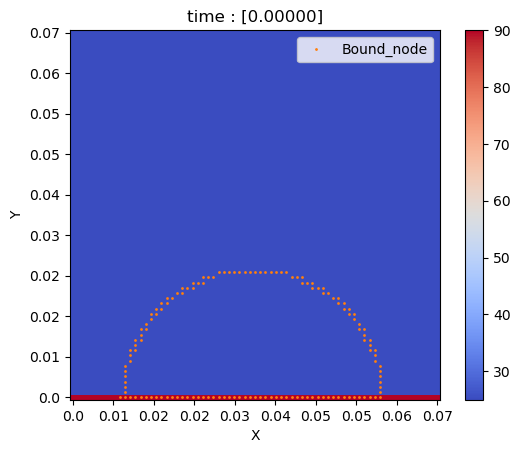

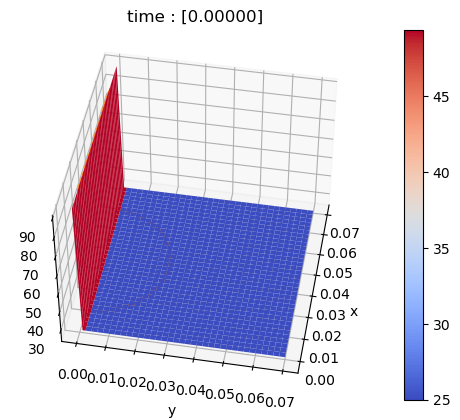

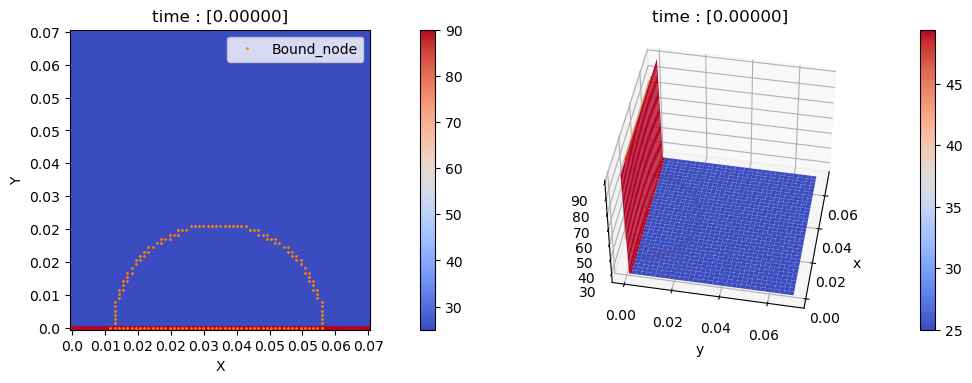

Mesh has been compiled.


In [2]:
try : 
    del temp
except : 
    pass

temp = FEM_2D(X=0.07, Y=0.07, dx=0.001, dy=0.001)
temp.build_mesh(k=237, alpha=9.785705437879351e-05, h=20, T_mat=25, T_inf=25)
temp.set_circle(x_mid_cord=0.07 / 2, R=0.025)

temp.set_BC_const_T(90, Y_axis=[0])
temp.plot_status_2D(show_node=True)
temp.plot_status_3D(alpha=1, show_node=True)
temp.plot_status(alpha=1, azim=190, show_node=True)
temp.compile()

In [4]:
dt = 0.00025
t_end = 3
temp.is_good(dt, t_end)

[Safe to compute]
	==> [1021]        nodes to calculate.
	==> [12000]       frames to repeat
	==> [1.23e+07]    times to calculate.
	==>  25.2s]   estimated.



[Safe to compute]
	==> [1021]        nodes to calculate.
	==> [10000000]    frames to repeat
	==> [1.02e+10]    times to calculate.
	==> [283h 36m 40.0s] estimated.

Computing mesh... [/] --> [AVG temperature : 42.74191][>                             ][31244/10000000]			

Temperature has been converged.
[7.81750] sec to converge.

Precision : [9.998444738812395e-06]
	==> previous temperature :  [42.74191]               
	==> current temperature :  [42.74191]               

Computing has been finished.


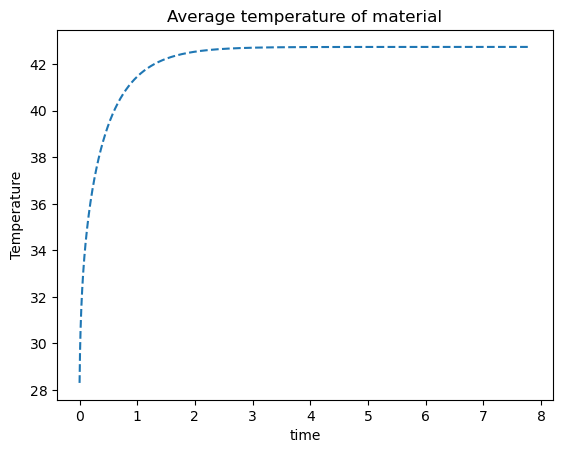

In [5]:
temp.compute_steady_state(dt, tol=1.0e-5, max_iter=1.0e+7)
temp.plot_process('--')


Computing has been finished.


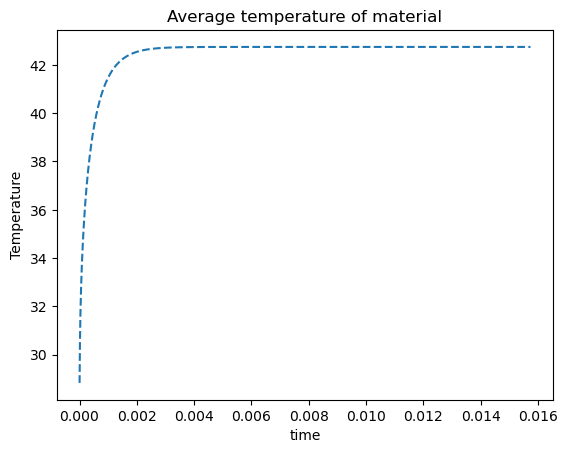

In [5]:
# temp.compute_dt(dt, save_process=True, save_init=True)
temp.compute(3, dt, save_process=True)
temp.plot_process('--')

In [76]:
temp.save_result(file_name="test_save")

T_mesh has been saved at : [/Users/jeongjunsang/Desktop/대학교 수업자료 : 공부/4-1/기타/전산물리/기말 프로젝트/test/test_save.npz]


In [78]:
time, average, t_mesh = temp.import_result(file="test_save.npz", replace_model=False)

print(time.shape, average.shape, t_mesh.shape)

(201,) (201,) (71, 71)


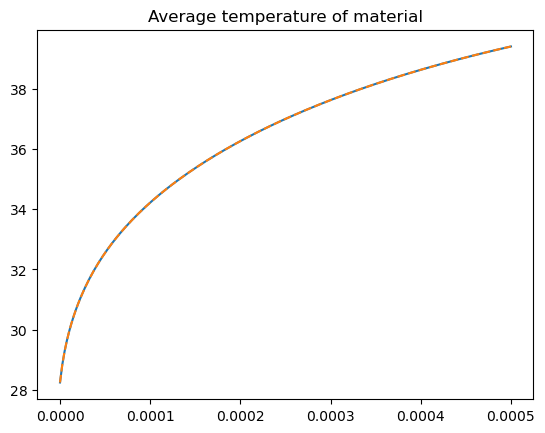

In [80]:
import matplotlib.pyplot as plt

plt.plot(time, average)

temp.import_result(file="test_save.npz", replace_model=True)
temp.plot_process('--')
